# RESTfulSwarm


In [180]:
%matplotlib inline
import pymongo as mg
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


# return a mongodb client
def get_client(usr, pwd, address, port='27017'):
    url = 'mongodb://%s:%s@%s:%s/RESTfulSwarmDB' % (usr, pwd, address, port)
    return mg.MongoClient(url)


# return a database object
def get_db(client, db_name):
    return client[db_name]


# return a collection cursor object
def get_col(db, col_name):
    return db[col_name]


# query data in a job collection
def query_col(col):
    return list(col.find({}))[0]


# get a list of job collection name
def get_all_cols(db):
     return db.collection_names()

In [181]:
def get_time(data):
    result = {'waiting_time': 0, 'execution_time': 0, 'total_time': 0}
    if len(data) == 0:
        return None
    submit_time = data['submit_time']
    start_time = data['start_time']
    end_time = data['end_time']
    
    waiting_time = start_time - submit_time
    result['waiting_time'] = waiting_time
    
    execution_time = end_time - start_time
    result['execution_time'] = execution_time
    
    total_time = end_time - submit_time
    result['total_time'] = total_time
    return result


In [182]:
def plot_graph(db):
    cols = get_all_cols(db)
    waiting_time = []
    execution_time = []
    total_time = []
    jobs = []
    for col in cols:
        if 'job' not in col:
            continue
        col_obj = get_col(db, col)
        job_info = query_col(col_obj)
        result = get_time(job_info)
        if result['waiting_time'] <= 0 or result['execution_time'] <= 0 or result['total_time'] <= 0:
            continue
        waiting_time.append(result['waiting_time'])
        execution_time.append(result['execution_time'])
        total_time.append(result['total_time'])
        jobs.append(col)
    return waiting_time, execution_time, total_time, jobs


In [183]:
client = get_client('admin', 'kzw', '129.114.108.18')
db = get_db(client, 'RESTfulSwarmDB')


In [184]:
graph_data = plot_graph(db)
waiting_time = graph_data[0]
execution_time = graph_data[1]
total_time = graph_data[2]
jobs = graph_data[3]


In [185]:
def plot_waiting_time():
    wt = pd.Series(waiting_time, index=jobs)
    wt.plot.line(figsize=(10, 5))
    plt.xlabel('Job')
    plt.ylabel('Waiting Time(s)')
    plt.title('Job Waiting Time')

In [186]:
def plot_execution_time():
    et = pd.Series(execution_time, index=jobs)
    et.plot.line(figsize=(10, 5))
    plt.xlabel('Job')
    plt.ylabel('Execution Time(s)')
    plt.title('Job Execution Time')


In [187]:
def plot_total_time():
    tt = pd.Series(total_time, index=jobs)
    tt.plot.line(figsize=(10, 5))
    plt.xlabel('Job')
    plt.ylabel('Total Time(s)')
    plt.title('Job Total Time')


In [188]:
def plot_resource_graph():
    workers_resource_col = get_col(db, 'WorkersResourceInfo')
    data = list(workers_resource_col.find({}))
    hostnames = [worker['hostname'] for worker in data]
    time_stamps = []
    for worker in data:
        for detail in worker['details']:
            time_stamps.append(detail[0])
    time_stamps = list(set(time_stamps))
    time_stamps.sort()
    utilization = np.zeros([len(hostnames), len(time_stamps)])
            
    def search_utilization(hostname, _time_stamp):
        for worker in data:
            if worker['hostname'] == hostname:
                for _detail in worker['details']:
                    if _detail[0] == _time_stamp:
                        return _detail[1]
        return 0
    
    for i, host in enumerate(hostnames[:]):
        for j, time_stamp in enumerate(time_stamps[:]):
            result = search_utilization(host, time_stamp)
            if result != -1:
                utilization[i, j] = result
            else:
                utilization[i, j] = utilization[i, j-1]
    
    df = pd.DataFrame(data=utilization, index=hostnames, columns=time_stamps)
    
    return sns.heatmap(data=df, vmin=0, vmax=1, center=0, cmap="Greens")

### WaitingTime vs Job


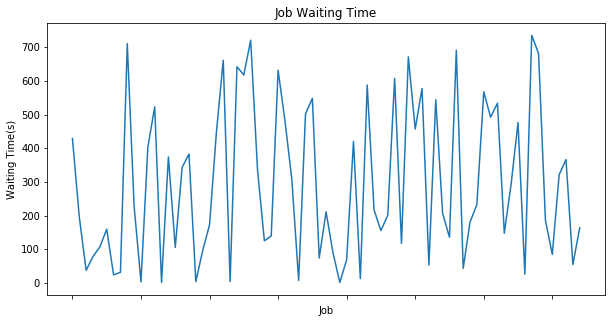

In [189]:
plot_waiting_time()

### ExecutionTime vs Job


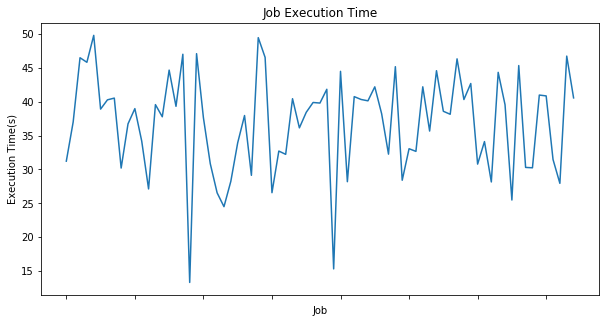

In [190]:
plot_execution_time()


### TotalTime vs Job


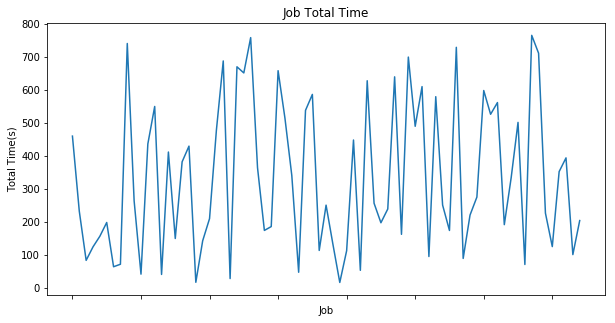

In [191]:
plot_total_time()


### Workers Resource Utilization Graph


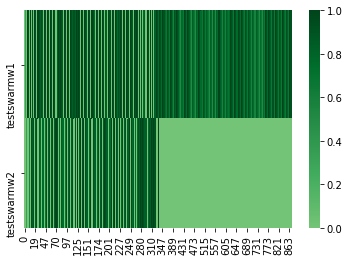

In [192]:
plot_resource_graph()